In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [2]:
from src.utils.custom_gates import ConversionGainGate
from src.utils.polytope_wrap import monodromy_range_from_target, coverage_to_haar_expectation
from src.basis import CircuitTemplate, MixedOrderBasisCircuitTemplate
from src.utils.visualize import unitary_to_weyl, unitary_2dlist_weyl, coordinate_2dlist_weyl
from src.utils.custom_gates import CustomCostGate
from qiskit.circuit.library import CXGate, SwapGate
from weylchamber import c1c2c3
from src.utils.snail_death_gate import SpeedLimitedGate
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# # verifying that relative phase doesn't change 2Q gate location
# unitary = [ConversionGainGate(0, 0, p*0.5*np.pi, (1-p)*0.4*np.pi) for p in np.linspace(0,1,16)]
# print([u.cost() for u in unitary])
# unitary_to_weyl(*unitary);

In [4]:
#the first version of this file was exploring the conversion gain hamiltonian, let's also explore Heavy-Fluxonion, and Flux Qubit


In [5]:
from src.scripts.gate_exploration.bgatev2script import build_gates, collect_data, get_group_name, cost_scaling, pick_winner, plot_eharr

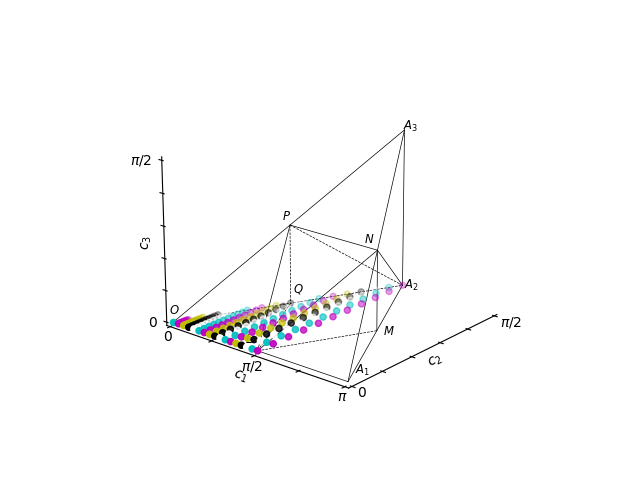

In [6]:
unitary_list, coordinate_list = build_gates()
coordinate_2dlist_weyl(*coordinate_list);

In [7]:
# ## %%
#TODO put this in its own file
# """use 2 different 2Q gates and see minimum cost to build SWAP
# just see if a solution exists for 2Q gates only using 2 instances of each gate then stop (rather than using coverage set)"""
# from src.utils.polytope_wrap import get_polytope_from_circuit, unitary_to_monodromy_coordinate
# from qiskit import QuantumCircuit
# from qiskit.circuit.library import SwapGate
# import itertools

# # interested in a hetero basis of 2 applications to build a SWAP target
# target_coords = unitary_to_monodromy_coordinate(SwapGate().to_matrix())

# #taking product over search space to build pairs of gates
# # a - might want to remove constraint of left side of x-axis only (I'm not sure if this makes a difference or not)
# # b - may need to increase density of gates to sample from
# unitary_pairs = list(itertools.product(unitary_list, repeat=2))

# #if find a solution, save it 
# sol = []

# for gate1, gate2 in tqdm(unitary_pairs):

#     #basis can just be a circuit with 2Q gates
#     basis = QuantumCircuit(2)
#     basis.append(gate1, [0,1])
#     basis.append(gate2, [0,1])

#     circuit_polytope = get_polytope_from_circuit(basis) 

#     if circuit_polytope.has_element(target_coords):
#         sol.append((gate1, gate2))
#         logging.info((gate1, gate2))

# print(sol)
#XXX

In [8]:
# template = MixedOrderBasisCircuitTemplate(base_gates=[CustomCostGate(CXGate(), "CX")], chatty_build=1)
# coverage_to_haar_expectation(template.coverage, chatty=1)

First minor problem I am facing is that when counting 1Q gates, I am adding a 1/10 iswap duration for each layer of 1Q gates. This adds a 1Q layer following each 2Q layer; but there should actually be 1 additional layer of 1Q not being counted. (think if we have a single 2Q layer then there are two 1Q layers because one on each side). To fix this would be kind of complicated so I am using the approximation for now.

I can fix this for the cnot and swap score calcs by offsetting by a single 1Q layer but I can't figure out how to do this for the haar score calculation because the polytope costs are created in a strange way. For now I will ignore the offset on cnot and swap scores for consistency.

Second, assumes between each 2Q layer is a 1Q layer (but for some decomps they could go away) for example SWAP out of CNOTs requires 3 CNOTs and 0 1Q gates. I think this is a fine approximation still.


If I had better control over polytope costs, I feel like I should only need to compute the coverage sets once, and then be able to apply a shifting 1Q cost - but for now I can't figure out how to do that - which means I have to recompute the expensive set of data over again!

I think I could fix these both problems. What I need to do is to treat each gate with a constant cost = 1, that way the coverage cost is only representing the number of repetitions. Then later I can scale by cost of the 2Q gate, and add cost of 1Q gates easily too. This fixes the problem of 1Q gates as well as not needing to recompute the entire data sets when wanting to change the costs of the gate!

In [9]:
# set logger level to debug
# logger.setLevel(logging.DEBUG)
collect_data(unitary_list)

100%|██████████| 176/176 [00:00<00:00, 15131.65it/s]


INFO:root:winner: 2QGate(0.00000000, 0.78539816, 1.00000000), scores: [1.42592958 1.3        1.9       ], cost: 0.5
INFO:root:scaled scores: [ 0.71296479  0.65        0.95       -0.25       -0.25      ], scaled cost: 0.5


(Instruction(name='2QGate(0.00000000, 0.78539816, 1.00000000)', num_qubits=2, num_clbits=0, params=[0.0, 0.0, 0.0, 0.7853981633974483, 1.0]),
 Instruction(name='2QGate(0.00000000, 0.78539816, 1.00000000)', num_qubits=2, num_clbits=0, params=[0.0, 0.0, 0.0, 0.7853981633974483, 1.0]))

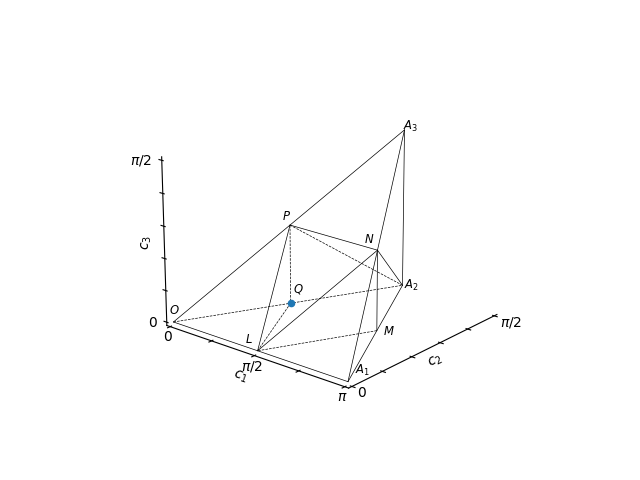

In [10]:
method = 'linear'
duration_1q = 0.1
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name, metric=0)
pick_winner(group_name, metric=2)

INFO:root:[0.         0.         0.03926991 0.74612826 1.        ]
INFO:root:[ 1.30615039  1.22906977  2.35813953 -0.46453488 -0.46453488]
INFO:root:0.5


Instruction(name='2QGate', num_qubits=2, num_clbits=0, params=[0.0, 0.0, 0.039269908169872414, 0.7461282552275759, 1.0])

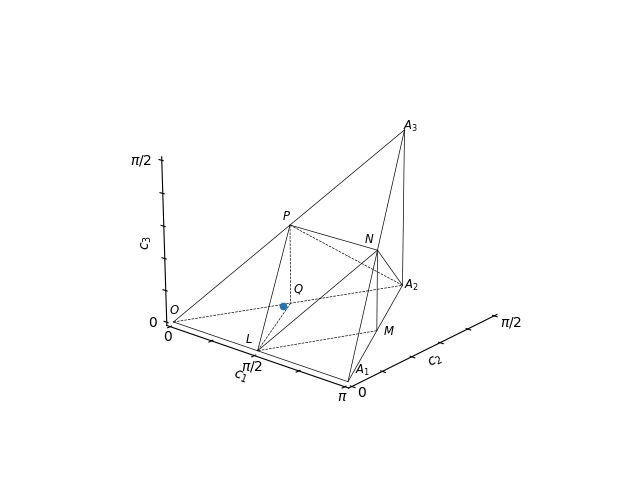

In [19]:
method = 'hardware'
duration_1q = 0.1
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
pick_winner(group_name)

INFO:root:[0.         0.         0.07853982 0.70685835 1.        ]
INFO:root:[ 1.33029561  1.24        2.38       -0.47       -0.47      ]
INFO:root:0.5


Instruction(name='2QGate', num_qubits=2, num_clbits=0, params=[0.0, 0.0, 0.07853981633974483, 0.7068583470577035, 1.0])

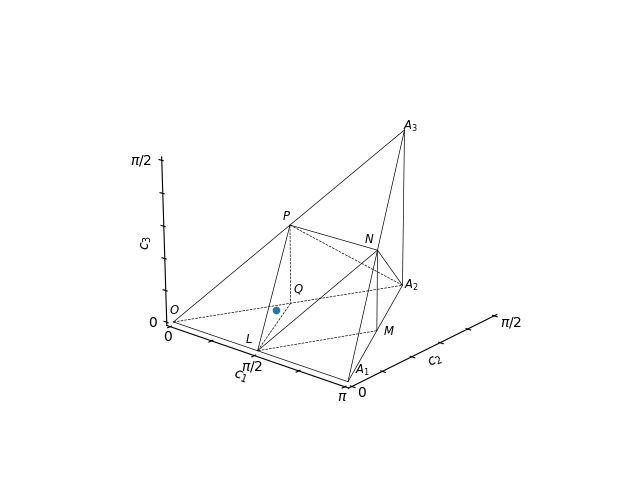

In [17]:
method = 'mid'
duration_1q = 0.1
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
#plot_eharr(group_name, metric=0)
pick_winner(group_name, metric=0)

INFO:root:[0.         0.         0.11780972 0.66758844 1.        ]
INFO:root:[ 1.29132671  1.16223022  2.22446043 -0.43111511 -0.43111511]
INFO:root:0.5


Instruction(name='2QGate', num_qubits=2, num_clbits=0, params=[0.0, 0.0, 0.11780972450961726, 0.667588438887831, 1.0])

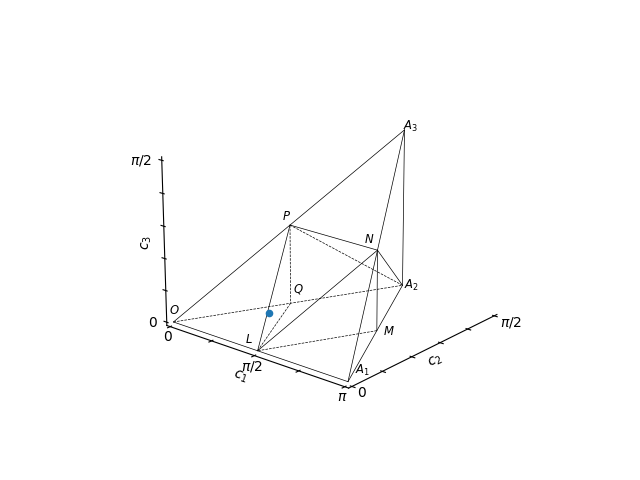

In [16]:
method = 'squared'
duration_1q = 0.1
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name, metric=0)
pick_winner(group_name, metric=0)